In [1]:
import math
import tqdm
import itertools
import copy
import types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# PyTorch
import torch
torch.manual_seed(42)
import gpytorch

/cluster/tufts/hugheslabkp/eharve06/miniconda3/envs/l3d_2024f_cuda12_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses
import utils

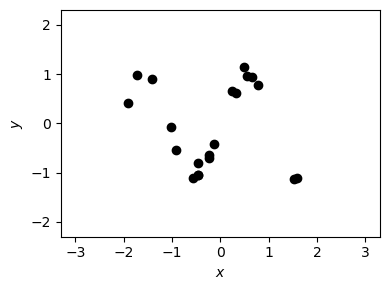

In [3]:
N = 20
random_state = np.random.RandomState(42)
X_numpy = random_state.randn(N, 1)
y_numpy = np.sin(3 * X_numpy) + 0.1 * random_state.randn(N, 1)

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

X_train, X_val = X[:int((4/5)*N)], X[int((4/5)*N):]
y_train, y_val = y[:int((4/5)*N)], y[int((4/5)*N):]

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy, y_numpy, color='#000000')
ax.set_xlim([-3.3, 3.3])
ax.set_ylim([-2.3, 2.3])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [4]:
def loss_closure(loss_fn, model, X, y, optimizer, **kwargs):
    optimizer.zero_grad()
    loss = -loss_fn(model, X, y, **kwargs)
    loss.backward()
    return loss

def fit(model, init_state_dict, loss_fn, X, y, lrs=[0.1, 0.01, 0.001, 0.0001], **kwargs):

    best_state_dict = None
    best_metric = np.inf

    for lr in lrs:
        model.load_state_dict(init_state_dict)
        optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=10_000, line_search_fn='strong_wolfe')
        loss = optimizer.step(lambda: loss_closure(loss_fn, model, X, y, optimizer, **kwargs))

        if loss.item() < best_metric:
            best_state_dict = copy.deepcopy(model.state_dict())
            best_metric = loss.item()
    
    model.load_state_dict(best_state_dict)

In [5]:
def log_evidence(model, X, y):
    N, C = X.shape
    Phi = model.featurize(X).T
    cov = model.noise**2 * torch.eye(N) + Phi.T @ Phi
    cov_inv = torch.inverse(cov)
    cov_logdet = torch.logdet(cov)
    return -(1/2) * (N * torch.log(torch.tensor(2 * torch.pi)) + cov_logdet) - (1/2) * y.T @ cov_inv @ y

def posterior(model, X, y):
    Phi = model.featurize(X).T    
    D, N = Phi.shape
    cov = torch.inverse(torch.eye(D) + Phi @ torch.inverse(model.noise**2 * torch.eye(N)) @ Phi.T)
    mu = cov @ (Phi @ torch.inverse(model.noise**2 * torch.eye(N)) @ y)
    return mu, cov

In [6]:
rff = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1, learnable_lengthscale=True, learnable_noise=True, learnable_outputscale=True, lengthscale=1.0, noise=0.01, outputscale=1.0)
init_state_dict = copy.deepcopy(rff.state_dict())

fit(rff, init_state_dict, log_evidence, X, y)
mu_q, Sigma_q = posterior(rff, X, y)

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    rng = np.random.default_rng(42)
    rff_preds = []
    for _ in tqdm.tqdm(range(10_000)):
        sample = rng.multivariate_normal(mean=mu_q.view(-1), cov=Sigma_q, check_valid='ignore', method='svd')
        rff.linear.weight.data = torch.tensor(sample, dtype=torch.float).view(1, -1)
        rff_preds.append(rff(linspace).view(-1) + rff.noise * torch.randn((1000,)))
    rff_preds = torch.stack(rff_preds, dim=-1)

100%|██████████| 10000/10000 [1:15:57<00:00,  2.19it/s]


In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones((N,)))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp = ExactGPModel(X, y.view(-1), likelihood)

optimizer = torch.optim.Adam(gp.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

gp.train()
likelihood.train()

for epoch in tqdm.tqdm(range(10_000)):
    optimizer.zero_grad()
    output = gp(X)
    loss = -mll(output, y.view(-1)).sum()
    loss.backward()
    optimizer.step()

gp.eval()
likelihood.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000)
    gp_preds = likelihood(gp(linspace))
    gp_samples = gp_preds.sample(torch.Size((3,)))

100%|██████████| 10000/10000 [00:40<00:00, 249.24it/s]


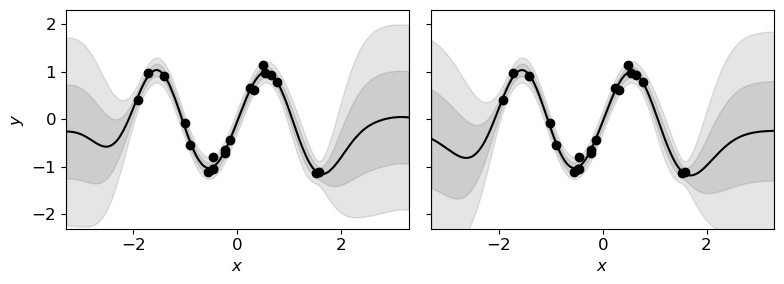

In [8]:
plt.rcParams.update({'font.size': 12})

linspace = np.linspace(start=-3.3, stop=3.3, num=1000)

ncols, nrows = 2, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')

axs[0].scatter(X_numpy, y_numpy, color='#000000')
axs[0].fill_between(linspace, rff_preds.mean(dim=-1)+2*rff_preds.std(dim=-1), rff_preds.mean(dim=-1)-2*rff_preds.std(dim=-1), alpha=0.1, color='#000000')
axs[0].fill_between(linspace, rff_preds.mean(dim=-1)+1*rff_preds.std(dim=-1), rff_preds.mean(dim=-1)-1*rff_preds.std(dim=-1), alpha=0.1, color='#000000')
axs[0].plot(linspace, rff_preds.mean(dim=-1), color='#000000')
axs[0].set_xlim([-3.3, 3.3])
axs[0].set_ylim([-2.3, 2.3])
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$y$')

axs[1].scatter(X_numpy, y_numpy, color='#000000')
axs[1].fill_between(linspace, gp_preds.mean+2*gp_preds.stddev, gp_preds.mean-2*gp_preds.stddev, alpha=0.1, color='#000000')
axs[1].fill_between(linspace, gp_preds.mean+1*gp_preds.stddev, gp_preds.mean-1*gp_preds.stddev, alpha=0.1, color='#000000')
axs[1].plot(linspace, gp_preds.mean, color='#000000')
axs[1].set_xlim([-3.3, 3.3])
axs[1].set_ylim([-2.3, 2.3])
axs[1].set_xlabel(r'$x$')

fig.tight_layout()
fig.savefig('rff_gp_comparison.pdf', bbox_inches='tight')
plt.show()

In [9]:
def closed_form_ELBo(mu_q, Phi, Sigma_q, sigma_y, tau_star, y):
    
    R, N = Phi.shape

    term1 = y@y.T
    term2 = 2 * y @ mu_q.T @ Phi
    term3 = Phi.T @ (Sigma_q + mu_q @ mu_q.T) @ Phi
    expected_log_likelihood = -(N/2) * torch.log(2 * torch.pi * sigma_y**2) - (1/(2 * sigma_y**2)) * torch.trace(term1 - term2 + term3)

    term1 = (1/tau_star) * torch.trace(Sigma_q)
    term2 = (1/tau_star) * mu_q.T @ mu_q
    term3 = (R * torch.log(tau_star)) - torch.logdet(Sigma_q)
    kl = (1/2) * (term1 + term2 - R + term3)
    
    return expected_log_likelihood, kl

def closed_form_DE_ELBo(model, X, y, kappa=1.0):

    params = torch.nn.utils.parameters_to_vector(model.linear.parameters())
    mu = params.view(-1, 1)

    Phi = model.featurize(X).T
    R, N = Phi.shape
    
    cov = torch.nn.functional.softplus(model.sigma_param)**2 * torch.eye(R)
    
    expected_log_likelihood, kl = closed_form_ELBo(mu, Phi, cov, model.noise, torch.tensor(1.0), y)
        
    return (1/N) * expected_log_likelihood - (1/kappa) * (1/N) * kl

In [10]:
kappas = [1, 6, 51.2, 181, 1024]
means = torch.zeros(size=(len(kappas), 1000))
samples = torch.zeros(size=(len(kappas), 1000, 10_000))

rff.load_state_dict(init_state_dict)
rff.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
init_state_dict = copy.deepcopy(rff.state_dict())

for i, kappa in enumerate(kappas):
    
    fit(rff, init_state_dict, closed_form_DE_ELBo, X, y, kappa=kappa)
    
    with torch.no_grad():
        linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
        mu_q = copy.deepcopy(rff.linear.weight.data)
        means[i] = rff(linspace).view(-1)
        rng = np.random.default_rng(42)
        for j in range(10_000):
            rff.linear.weight.data = mu_q + torch.nn.functional.softplus(rff.sigma_param) * torch.randn_like(mu_q)
            samples[i,:,j] = rff(linspace).view(-1) + rff.noise * torch.randn((1000,))

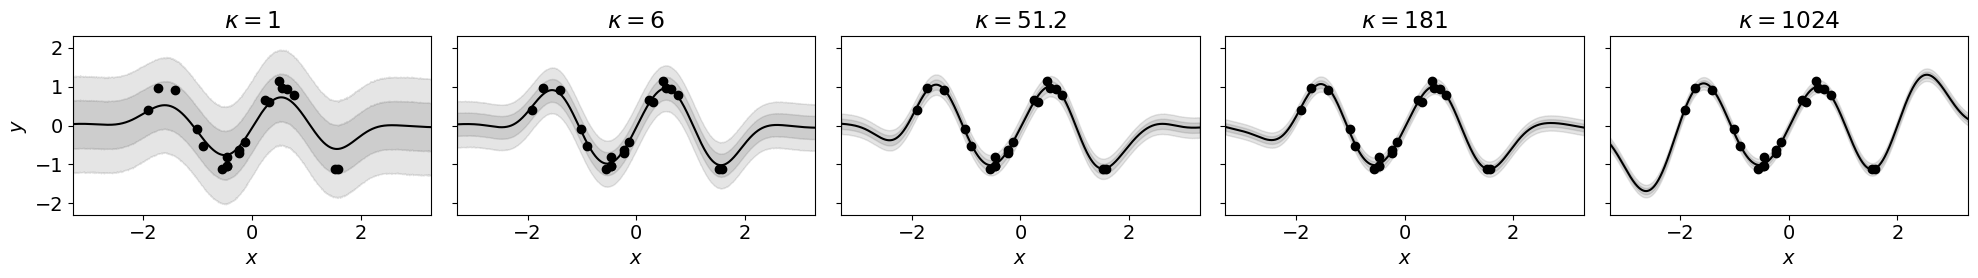

In [11]:
plt.rcParams.update({'font.size': 14})

linspace = np.linspace(start=-3.3, stop=3.3, num=1000)

ncols, nrows = 5, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')

axs[0].scatter(X_numpy, y_numpy, color='#000000')
axs[0].fill_between(linspace, samples[0].mean(dim=-1)+2*samples[0].std(dim=-1), samples[0].mean(dim=-1)-2*samples[0].std(dim=-1), alpha=0.1, color='#000000')
axs[0].fill_between(linspace, samples[0].mean(dim=-1)+1*samples[0].std(dim=-1), samples[0].mean(dim=-1)-1*samples[0].std(dim=-1), alpha=0.1, color='#000000')
axs[0].plot(linspace, means[0], color='#000000')
axs[0].set_xlim([-3.3, 3.3])
axs[0].set_ylim([-2.3, 2.3])
axs[0].set_yticks([-2, -1, 0, 1, 2])
axs[0].set_title(r'$\kappa=1$')
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$y$')

axs[1].scatter(X_numpy, y_numpy, color='#000000')
axs[1].fill_between(linspace, samples[1].mean(dim=-1)+2*samples[1].std(dim=-1), samples[1].mean(dim=-1)-2*samples[1].std(dim=-1), alpha=0.1, color='#000000')
axs[1].fill_between(linspace, samples[1].mean(dim=-1)+1*samples[1].std(dim=-1), samples[1].mean(dim=-1)-1*samples[1].std(dim=-1), alpha=0.1, color='#000000')
axs[1].plot(linspace, means[1], color='#000000')
axs[1].set_xlim([-3.3, 3.3])
axs[1].set_ylim([-2.3, 2.3])
axs[1].set_yticks([-2, -1, 0, 1, 2])
axs[1].set_title(r'$\kappa=6$')
axs[1].set_xlabel(r'$x$')

axs[2].scatter(X_numpy, y_numpy, color='#000000')
axs[2].fill_between(linspace, samples[2].mean(dim=-1)+2*samples[2].std(dim=-1), samples[2].mean(dim=-1)-2*samples[2].std(dim=-1), alpha=0.1, color='#000000')
axs[2].fill_between(linspace, samples[2].mean(dim=-1)+1*samples[2].std(dim=-1), samples[2].mean(dim=-1)-1*samples[2].std(dim=-1), alpha=0.1, color='#000000')
axs[2].plot(linspace, means[2], color='#000000')
axs[2].set_xlim([-3.3, 3.3])
axs[2].set_ylim([-2.3, 2.3])
axs[2].set_yticks([-2, -1, 0, 1, 2])
axs[2].set_title(r'$\kappa=51.2$')
axs[2].set_xlabel(r'$x$')

axs[3].scatter(X_numpy, y_numpy, color='#000000')
axs[3].fill_between(linspace, samples[3].mean(dim=-1)+2*samples[3].std(dim=-1), samples[3].mean(dim=-1)-2*samples[3].std(dim=-1), alpha=0.1, color='#000000')
axs[3].fill_between(linspace, samples[3].mean(dim=-1)+1*samples[3].std(dim=-1), samples[3].mean(dim=-1)-1*samples[3].std(dim=-1), alpha=0.1, color='#000000')
axs[3].plot(linspace, means[3], color='#000000')
axs[3].set_xlim([-3.3, 3.3])
axs[3].set_ylim([-2.3, 2.3])
axs[3].set_yticks([-2, -1, 0, 1, 2])
axs[3].set_title(r'$\kappa=181$')
axs[3].set_xlabel(r'$x$')

axs[4].scatter(X_numpy, y_numpy, color='#000000')
axs[4].fill_between(linspace, samples[4].mean(dim=-1)+2*samples[4].std(dim=-1), samples[4].mean(dim=-1)-2*samples[4].std(dim=-1), alpha=0.1, color='#000000')
axs[4].fill_between(linspace, samples[4].mean(dim=-1)+1*samples[4].std(dim=-1), samples[4].mean(dim=-1)-1*samples[4].std(dim=-1), alpha=0.1, color='#000000')
axs[4].plot(linspace, means[4], color='#000000')
axs[4].set_xlim([-3.3, 3.3])
axs[4].set_ylim([-2.3, 2.3])
axs[4].set_yticks([-2, -1, 0, 1, 2])
axs[4].set_title(r'$\kappa=1024$')
axs[4].set_xlabel(r'$x$')

fig.tight_layout()
fig.savefig('rff_varying_kappa.pdf', bbox_inches='tight')
plt.show()